In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e7/sample_submission.csv")

In [3]:
def data_overview(df, name="DataFrame", show_visuals=False):
    print(f"🧾 OVERVIEW: {name}")
    print("=" * 70)
    
    # Shape
    print(f"📐 Shape: {df.shape}")
    print("=" * 70)
    
    # Data Types and Info
    print("📋 Data Types and Memory Usage:")
    print(df.info())
    print("=" * 70)

    # Missing Values
    nulls = df.isnull().sum()
    null_percent = (nulls / len(df)) * 100
    null_df = pd.DataFrame({"Missing Values": nulls, "% Missing": null_percent})
    print("❓ Missing Values:")
    print(null_df[null_df["Missing Values"] > 0].sort_values(by="% Missing", ascending=False))
    print("=" * 70)

    # Unique Value Counts
    print("🔢 Unique Values per Column:")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")
    print("=" * 70)

    # Descriptive Stats
    print("📊 Statistical Summary (Numerical):")
    display(df.describe().T)
    print("=" * 70)

    # Sample Records
    print("🔍 Sample Rows:")
    display(df.head(5))
    print("=" * 70)

    # Cardinality Check (useful for modeling)
    print("🧠 Column Cardinality:")
    cardinality = df.apply(lambda x: x.nunique()).sort_values()
    display(cardinality)

    # Visuals
    if show_visuals:
        import matplotlib.pyplot as plt
        import seaborn as sns
        sns.set(style="whitegrid")

        numeric_cols = df.select_dtypes(include=[np.number]).columns
        df[numeric_cols].hist(bins=20, figsize=(15, 10))
        plt.suptitle(f"📈 Histograms of Numeric Features - {name}", fontsize=16)
        plt.tight_layout()
        plt.show()

🧾 OVERVIEW: Train Data
📐 Shape: (18524, 9)
📋 Data Types and Memory Usage:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB
None
❓ Missing Values:
                           Missing Values  % Missing
Stage_fear                           1893  10.219175
Going_outsi

,count,mean,std,min,25%,50%,75%,max
id,18524.0,9261.500000,5347.562529,0.0,4630.75,9261.5,13892.25,18523.0
Time_spent_Alone,17334.0,3.137764,3.003786,0.0,1.00,2.0,4.00,11.0
Social_event_attendance,17344.0,5.265106,2.753359,0.0,3.00,5.0,8.00,10.0
Going_outside,17058.0,4.044319,2.062580,0.0,3.00,4.0,6.00,7.0
Friends_circle_size,17470.0,7.996737,4.223484,0.0,5.00,8.0,12.00,15.0
Post_frequency,17260.0,4.982097,2.879139,0.0,3.00,5.0,7.00,10.0


🔍 Sample Rows:


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


🧠 Column Cardinality:


Stage_fear                       2
Drained_after_socializing        2
Personality                      2
Going_outside                    8
Social_event_attendance         11
Post_frequency                  11
Time_spent_Alone                12
Friends_circle_size             16
id                           18524
dtype: int64

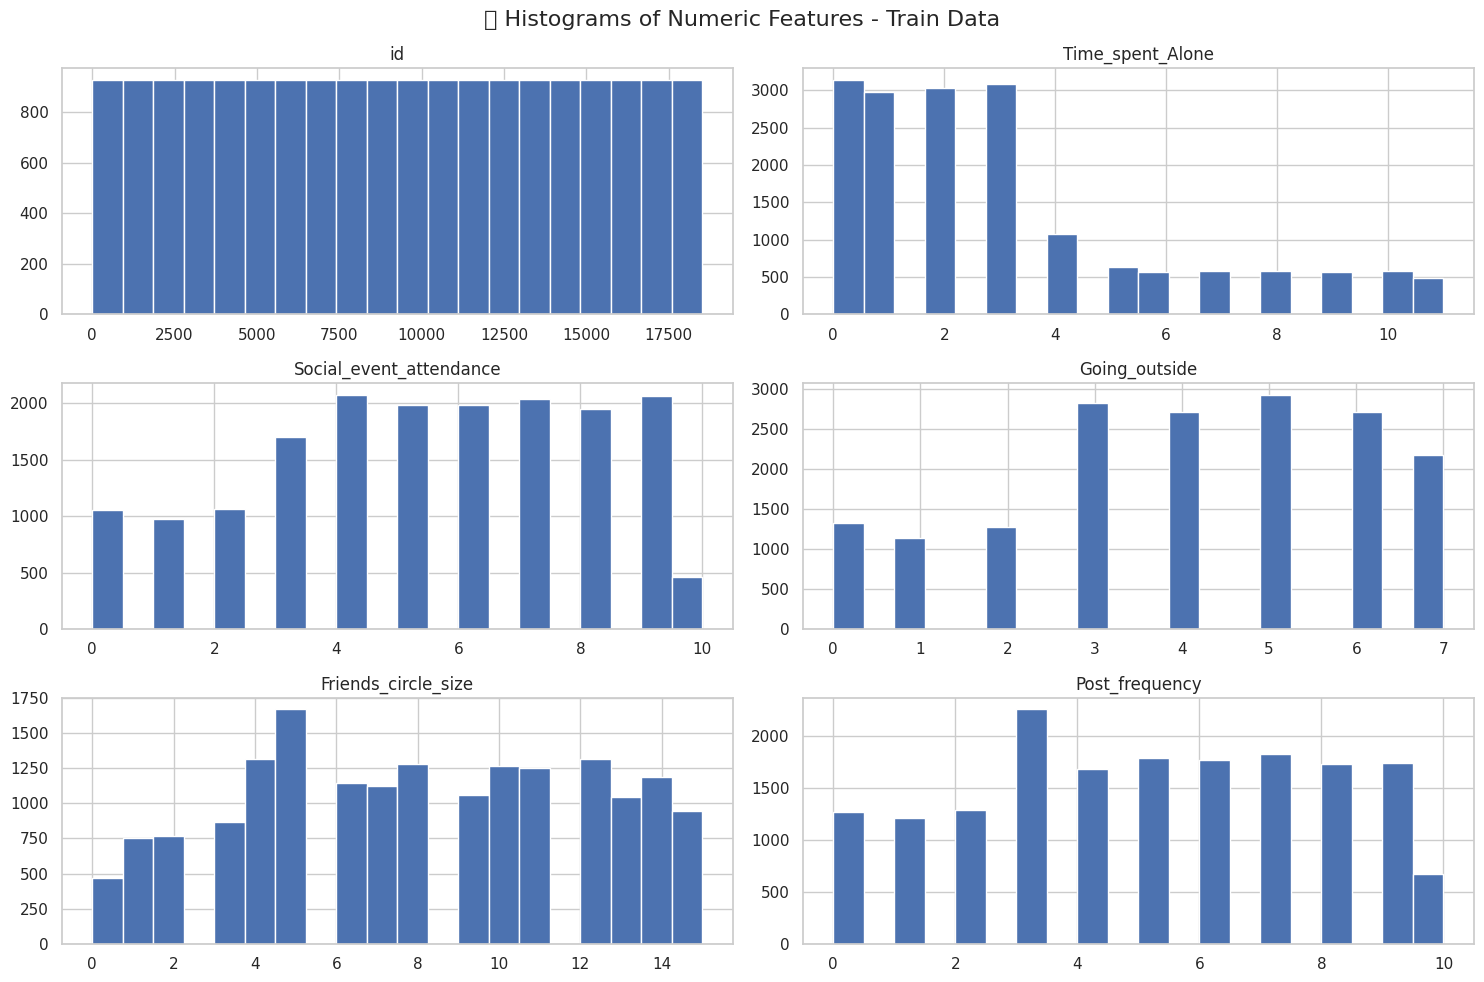

In [4]:
data_overview(train, name="Train Data", show_visuals=True)

In [5]:
def preprocess_train_and_test(train_df, test_df):
    train = train_df.copy()
    test = test_df.copy()

    # Boolean conversion
    bool_cols = ['Stage_fear', 'Drained_after_socializing']
    for col in bool_cols:
        for df in [train, test]:
            df[col] = df[col].fillna("No").replace({"Yes": 1, "No": 0}).astype(int)

    # Impute numeric columns with train median
    for col in train.columns:
        if train[col].dtype in ['float64', 'int64']:
            median = train[col].median()
            train[col].fillna(median, inplace=True)
            test[col].fillna(median, inplace=True)

    # Drop ID column if it exists
    if 'id' in train.columns:
        train.drop(columns='id', inplace=True)
    if 'id' in test.columns:
        test.drop(columns='id', inplace=True)

    # Drop target if exists (you’ll split it later)
    if 'Personality' in train.columns:
        train.drop(columns='Personality', inplace=True)

    # Scale
    scaler = StandardScaler()
    train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns)

    # Feature engineering
    for df in [train_scaled, test_scaled]:
        df['Social_ratio'] = df['Social_event_attendance'] / (df['Friends_circle_size'] + 1)
        df['Outside_diff'] = df['Going_outside'] - df['Drained_after_socializing']

    return train_scaled, test_scaled

In [6]:
X_train_df, X_test_df = preprocess_train_and_test(train, test)
y = train['Personality'].map({'Extrovert': 0, 'Introvert': 1})

In [7]:
def evaluate_model_cv(model, X, y, folds=5):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    accuracies = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_val_fold)
        acc = accuracy_score(y_val_fold, preds)
        print(f"Fold {fold} Accuracy: {acc:.4f}")
        accuracies.append(acc)

    print(f"\n✅ Average Accuracy: {np.mean(accuracies):.4f}")
    return model

In [8]:
xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=42)
lgb = LGBMClassifier(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
cat = CatBoostClassifier(n_estimators=300, learning_rate=0.05, max_depth=5, verbose=0, random_state=42)

print("🔷 XGBoost:")
xgb_model = evaluate_model_cv(xgb, X_train_df, y)

print("\n🟢 LightGBM:")
lgb_model = evaluate_model_cv(lgb, X_train_df, y)

print("\n🟡 CatBoost:")
cat_model = evaluate_model_cv(cat, X_train_df, y)

🔷 XGBoost:
Fold 1 Accuracy: 0.9698
Fold 2 Accuracy: 0.9655
Fold 3 Accuracy: 0.9663
Fold 4 Accuracy: 0.9698
Fold 5 Accuracy: 0.9706

✅ Average Accuracy: 0.9684

🟢 LightGBM:
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260476 -> initscore=-1.043494
[LightGBM] [Info] Start training from score -1.043494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [9]:
final_preds = cat_model.predict(X_test_df)

# Create submission
submission = pd.DataFrame({
    'id': sample_submission['id'],  # Original test IDs
    'Personality': ['Extrovert' if p == 0 else 'Introvert' for p in final_preds]
})

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved!")

✅ submission.csv saved!
